# Imports

In [1]:
#!pip install -U scikit-learn

In [2]:
from Transformation import Transformation
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [3]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [4]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [5]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [6]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([0.1, 0.1, 0.1]).reshape(1, -1)  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))                               #list of "output_dimension" for each "list_node" element
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):       # for each node and its adjacency nodes
            neigh_nodes = np.array(list(dict_neigh.keys()))                                             # array of adjacency nodes
            diff = np.subtract(current_node, neigh_nodes)                                               # Compute the differences between current_node and all neighbor nodes   (x_i - x_j)
            neigh_distances = np.linalg.norm(self.W_theta * diff, axis=1)                               # Compute the norm for each vector difference  ||W_theta * (x_i - x_j)||
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                   # Add (W_phi * ||W_theta * (x_i - x_j)||) to the inclusion score list

        if len(previous_inclusion_score)==0:                            # return if no previous inclusion score
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        if list_inc_score.shape[1]!=1:                                  # If inclusion score is not vector
            list_inc_score = np.mean(list_inc_score, axis=1)            # Mean the matrix for each node

        # array of array to array
        if len(list_inc_score.shape)==2:                 
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [7]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[0.35651593 0.35672336 0.35651593 ... 0.33190433 0.48178618 0.33190433]
[0.50622637 0.50652089 0.50622637 ... 0.4712797  0.68410089 0.4712797 ]
[0.7024245  0.70252894 0.7024245  ... 0.68988442 0.76145154 0.68988442]
(5999,)


### Multinomial Sampling

In [8]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 1 0 ... 0 0 0]


In [9]:
target_number_point = min(len(graph._node), 100)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(78.8188, 8.722893, 87.81436), (81.614365, 8.722893, 85.01881), (79.48927, 8.722893, -2.3789573), (89.59702, 6.620764, 29.6), (76.10664, -5.0095077, 2.6933587), (39.0, 7.4193583, 94.73214), (81.04593, 8.610001, 0.30938062), (76.80688, -8.610001, 87.94336), (79.47574, 2.3044074, -12.903679), (81.178955, 8.722893, -0.6892752), (91.720764, 2.9401166, 0.2458914), (76.14782, -4.4479885, 3.427052), (75.562805, -3.0965528, 29.6), (76.18051, -4.4479885, 3.5490744), (76.47152, -4.871695, 29.6), (76.04695, -6.9390492, 84.422195), (85.25266, -1.6554987, -10.3115835), (51.0, -8.399635, 87.37586), (51.0, -8.57404, 88.01863), (39.0, -8.699333, 88.672745), (75.0, -0.66553295, 3.7747972), (90.52928, 5.670694, 42.5), (81.06128, 8.760632, 88.68506), (84.582214, 0.33300498, -10.955316), (91.25766, -2.9401166, 86.48244), (91.51184, -2.9401166, 85.62434), (87.44062, 0.33300498, -8.640622), (88.07466, 0.33300498, -7.9724813), (92.59843, 0.16653232, 42.5), (89.75532, 0.33300498, -5.782214), (77.13215, -6.93

# KNN

In [10]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[78.8188, 8.722893, 87.81436], [81.614365, 8.722893, 85.01881], [79.48927, 8.722893, -2.3789573], [89.59702, 6.620764, 29.6], [76.10664, -5.0095077, 2.6933587], [39.0, 7.4193583, 94.73214], [81.04593, 8.610001, 0.30938062], [76.80688, -8.610001, 87.94336], [79.47574, 2.3044074, -12.903679], [81.178955, 8.722893, -0.6892752], [91.720764, 2.9401166, 0.2458914], [76.14782, -4.4479885, 3.427052], [75.562805, -3.0965528, 29.6], [76.18051, -4.4479885, 3.5490744], [76.47152, -4.871695, 29.6], [76.04695, -6.9390492, 84.422195], [85.25266, -1.6554987, -10.3115835], [51.0, -8.399635, 87.37586], [51.0, -8.57404, 88.01863], [39.0, -8.699333, 88.672745], [75.0, -0.66553295, 3.7747972], [90.52928, 5.670694, 42.5], [81.06128, 8.760632, 88.68506], [84.582214, 0.33300498, -10.955316], [91.25766, -2.9401166, 86.48244], [91.51184, -2.9401166, 85.62434], [87.44062, 0.33300498, -8.640622], [88.07466, 0.33300498, -7.9724813], [92.59843, 0.16653232, 42.5], [89.75532, 0.33300498, -5.782214], [77.13215, -6.93

In [11]:
def connect_extended_graph(XYZ, number_neigh=15):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [12]:
extended_graph = connect_extended_graph(XYZ)

Number of nodes: 100
Number of edges: 1461


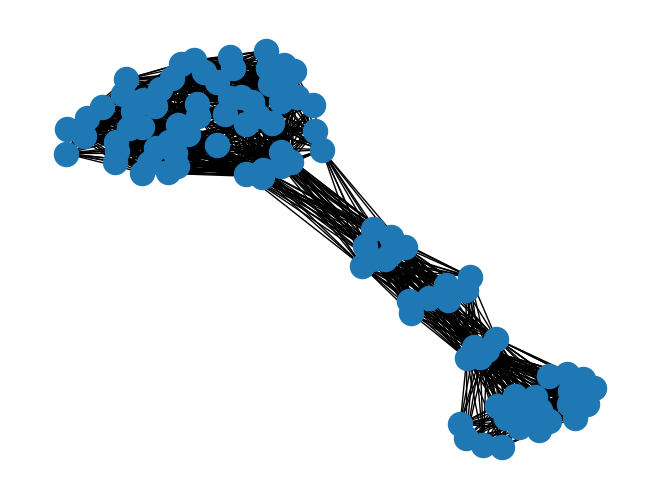

In [13]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [14]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
inclusion_score.shape

(100, 64)

In [15]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean

f = np.mean(inclusion_score, axis=1)                            # Flatten the matrix of inclusion score 
wq = np.random.rand(64)
wk = np.random.rand(64)

In [16]:
wq_f = wq.reshape(-1, 1) * f            # Wq*f
wk_f = wk.reshape(-1, 1) * f            # Wq*f
S = np.exp(np.dot(wq_f.T, wk_f))        # e^((wq_f.T)*(wk_f))

nodes = list(extended_graph.nodes())                                                                                # list of nodes
node_indices = {node: index for index, node in enumerate(nodes)}                                                    # dict{node: index}
neighbors_indices = [[node_indices[neighbor] for neighbor in extended_graph.neighbors(node)] for node in nodes]     # List of list : [[neigh1 of node1, neigh2 of node1...], [neigh1 of node2, neigh2 of node2...]...]


for index_current_node, neighbors_index in enumerate(neighbors_indices):        # For each neighbors of the 'index_current_node' node
    sum_columns = np.sum(S[:, neighbors_index], axis=1)                         # Sum along the rows the values of the neighbors
    S[index_current_node] = S[index_current_node] / sum_columns                 # And divide the current node columns by the sume of the neighbors

### Sparse Attention

# Face Candidates

#### Inputs

In [17]:
adjacency = nx.adjacency_matrix(extended_graph)
# S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 61)	1
  (0, 62)	1
  (0, 63)	1
  (0, 64)	1
  (0, 65)	1
  (0, 66)	1
  (0, 70)	1
  (0, 71)	1
  (0, 72)	1
  (0, 73)	1
  :	:
  (99, 53)	1
  (99, 54)	1
  (99, 55)	1
  (99, 56)	1
  (99, 57)	1
  (99, 58)	1
  (99, 59)	1
  (99, 60)	1
  (99, 74)	1
  (99, 75)	1
  (99, 76)	1
  (99, 77)	1
  (99, 78)	1
  (99, 82)	1
  (99, 85)	1
  (99, 86)	1
  (99, 87)	1
  (99, 88)	1
  (99, 89)	1
  (99, 90)	1
  (99, 91)	1
  (99, 92)	1
  (99, 96)	1
  (99, 97)	1
  (99, 98)	1
[[5.57397445e-09 1.83853888e-04 3.37299875e-09 ... 1.68980869e-04
  2.05703127e-04 6.68273659e-04]
 [6.18865328e+15 5.28377068e-12 5.01313665e-28 ... 3.95409795e-12
  7.77336659e-12 4.52805690e-10]
 [8.09875712e+34 2.43752192e-03 2.64173194e-08 ... 3.89241994e-04
  4.63188886e-04 1.31262522e-03]
 ...
 [3.51862727e+14 1.71388407e+11 4.79610710e+14 ... 1.69026859e-07
  2.490483

In [18]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


[[6.76831734e-04 7.75583114e+12 1.01496383e+32 ... 1.39122532e+13
  5.32688748e+12 1.07601999e+11]
 [7.75583114e+12 4.11596848e+05 2.69317310e+24 ... 7.00847661e+31
  2.69423767e+31 1.09137009e+29]
 [1.01496383e+32 2.69317310e+24 7.96308466e+32 ... 9.17161574e+50
  3.52580368e+50 1.42821724e+48]
 ...
 [1.39122532e+13 7.00847661e+31 9.17161574e+50 ... 2.10127132e+32
  8.27955413e+31 4.50222227e+29]
 [5.32688748e+12 2.69423767e+31 3.52580368e+50 ... 8.27955413e+31
  3.25603937e+31 1.75850642e+29]
 [1.07601999e+11 1.09137009e+29 1.42821724e+48 ... 4.50222227e+29
  1.75850642e+29 9.72390615e+26]]
(100, 100)


# Face Classifier

### TriConv

#### Inputs

In [19]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (80.14582, 8.672658, 90.11282)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (81.88645, 8.672658, 88.84818)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (81.614365, 8.722893, 85.01881)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (80.79131, 8.348472, 91.23085)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (77.39569, 6.9390492, 83.59569)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (78.402016, 7.328478, 83.164154)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (76.14388, 8.535009, 92.08333)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (85.80854, 8.535009, 82.9119)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (75.0, 0.0, 81.2)], [(78.8188, 8.722893, 87.81436), (81.06128, 8.760632, 88.68506), (75.22322, -3.2518802, 81.78151)], [(78.8188, 8.722893, 87.81436), (81.0

In [20]:
p_init = np.zeros((len(triangles)))

for index_triangle, triangle in enumerate(triangles):
    i = list(dict(extended_graph._node).keys()).index(triangle[0])
    j = list(dict(extended_graph._node).keys()).index(triangle[1])
    k = list(dict(extended_graph._node).keys()).index(triangle[2])
    p_init[index_triangle] = (A_s[i,j] + A_s[i,k] + A_s[j,k])/3
print(p_init)

[3.38321287e+31 5.79645673e+12 6.90691425e+12 ... 1.06530898e+38
 5.84757965e+38 5.80104181e+38]


#### Calculate barycenter

In [21]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[80.00863647460938, 8.718727111816406, 88.87074788411458], [80.58884684244792, 8.718727111816406, 88.44919840494792], [80.49814860026042, 8.735472361246744, 87.17273966471355], [80.22379557291667, 8.610665639241537, 89.24342854817708], [79.09192403157552, 8.140857696533203, 86.6983642578125], [79.4273681640625, 8.27066739400228, 86.55452473958333], [78.67465209960938, 8.672844568888346, 89.527587890625], [81.89620971679688, 8.672844568888346, 86.47043863932292], [78.29336039225261, 5.827841440836589, 85.89980061848958], [78.36776733398438, 4.7438812255859375, 86.09364827473958], [78.43229166666667, 4.7438812255859375, 86.05409749348958], [82.5770772298177, 5.05970573425293, 89.75687662760417], [78.64234415690105, 3.514825185139974, 86.973876953125], [83.71258036295573, 4.847802480061849, 87.66062418619792], [83.79730733235677, 4.847802480061849, 87.3745829264323], [82.79654947916667, 3.584747632344564, 87.62841796875], [79.2996114095052, 3.514825185139974, 86.41251627604167], [79.0427

In [22]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [23]:
graph_triangles = connect_triangle_graph(barycenters)
print(graph_triangles._node)

{(80.00863647460938, 8.718727111816406, 88.87074788411458): {'index_poly': {0, 1, 3, 6, 263, 265, 268, 20, 22, 283, 540, 286, 675, 44, 47, 303, 691, 826, 319, 453, 456, 470, 473, 988, 487, 488}}, (79.88157145182292, 8.643519719441732, 88.65010579427083): {'index_poly': {0, 1, 3, 6, 263, 265, 20, 22, 283, 540, 286, 675, 44, 47, 303, 689, 826, 317, 61, 64, 470, 473, 988, 487, 488}}, (80.28369140625, 8.689402262369791, 88.9251200358073): {'index_poly': {0, 1, 3, 263, 265, 20, 22, 283, 540, 286, 672, 675, 44, 300, 303, 691, 826, 319, 453, 456, 470, 473, 988}}, (80.22379557291667, 8.610665639241537, 89.24342854817708): {'index_poly': {0, 1, 3, 263, 265, 268, 20, 22, 283, 286, 675, 44, 47, 303, 691, 826, 319, 453, 456, 80, 470, 473, 988, 489}}, (79.60650634765625, 8.672844568888346, 88.59572347005208): {'index_poly': {0, 3, 6, 522, 268, 20, 22, 25, 286, 675, 44, 47, 303, 689, 826, 317, 64, 974, 80, 720, 473, 487, 488}}, (80.49886067708333, 8.581340789794922, 89.29779052734375): {'index_poly'

In [24]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=False, display_labels=False)

Number of nodes: 10363
Number of edges: 307943


#### calculate e norm matrix

In [25]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[2.4058766, 2.6545112, 1.6983277], [2.4058766, 3.2375584, 0.8457295], [2.4058766, 3.9535174, 3.7079282], [2.4058766, 3.96275, 2.5930314], [2.4058766, 4.796306, 6.531186], [2.4058766, 4.872631, 6.2931023], [2.4058766, 5.0412865, 5.9816327], [2.4058766, 8.539663, 7.4777484], [2.4058766, 11.594047, 13.019751], [2.4058766, 13.882317, 15.034706], [2.4058766, 13.885588, 15.015713], [2.4058766, 15.091555, 13.610073], [2.4058766, 16.263037, 17.023378], [2.4058766, 17.103361, 15.675626], [2.4058766, 17.376284, 15.984048], [2.4058766, 18.295387, 17.340725], [2.4058766, 16.483465, 17.061739], [2.4058766, 16.696943, 17.250937], [2.4058766, 17.449747, 17.89941], [2.4058766, 16.63109, 17.423931], [2.6545112, 3.2375584, 2.1515374], [2.6545112, 3.9535174, 5.3017125], [2.6545112, 3.96275, 1.3310677], [2.6545112, 4.796306, 7.2829714], [2.6545112, 4.872631, 7.2891483], [2.6545112, 5.0412865, 4.462885], [2.6545112, 8.539663, 9.1618], [2.6545112, 11.594047, 13.458564], [2.6545112, 13.882317, 15.356998], [

#### Calculate r

In [26]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

max_diff_vectors = np.array(diff_vectors).max(axis=1)
min_diff_vectors = np.array(diff_vectors).min(axis=1)

barycenters_numpy = np.array(barycenters)

# Calculate differences once to avoid redundant computations
diff_vectors = min_diff_vectors[:, np.newaxis] - min_diff_vectors
max_diff_vectors_diff = max_diff_vectors[:, np.newaxis] - max_diff_vectors
barycenters_diff = barycenters_numpy[:, np.newaxis, :] - barycenters_numpy

# Populate the r_matrix using vectorized operations
r_matrix = np.stack([diff_vectors, max_diff_vectors_diff, barycenters_diff[:, :, 0], barycenters_diff[:, :, 1], barycenters_diff[:, :, 2]], axis=-1)

print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

(10363, 10363, 5)


#### Calculate f

In [27]:
# MLP * 3 
f_final = p_init    # TODO

import torch
final_scores = torch.nn.functional.softmax(torch.tensor(f_final))
final_scores = final_scores.numpy()
print(final_scores.sum())
print(final_scores.shape)
print(final_scores)

1.0
(10363,)
[0. 0. 0. ... 0. 0. 0.]


C:\Users\Arthur\AppData\Local\Temp\ipykernel_13808\4023725568.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_scores = torch.nn.functional.softmax(torch.tensor(f_final))


# Simplified Mesh

In [28]:
selected_triangles_indexes = np.argpartition(final_scores, -target_number_point)[-target_number_point:] 
selected_triangles = np.array(triangles)[selected_triangles_indexes]
print(selected_triangles.shape) # number triangles, number points, number dimensions(x,y,z)

(100, 3, 3)


In [29]:
def create_triangle_graph(XYZ):
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(XYZ):
        for index_current_node in range(len(poly)):
            current_node = tuple(poly[index_current_node])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(poly[index_other_node])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_triangle'] = set()
                extended_graph.nodes[current_node]['index_triangle'].add(index_poly)
                if len(extended_graph.nodes[tuple(poly[index_other_node])])==0:
                    extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'] = set()
                extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'].add(index_poly)
    return extended_graph

In [30]:
simplified_final_graph = create_triangle_graph(selected_triangles)
print(simplified_final_graph._node)

{(81.178955, 8.722893, -0.6892752): {'index_triangle': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19}}, (79.26829, 7.9794145, 1.028143): {'index_triangle': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}}, (75.0, -0.66553295, 3.7747972): {'index_triangle': {0}}, (79.47574, 2.3044074, -12.903679): {'index_triangle': {1}}, (87.44062, 0.33300498, -8.640622): {'index_triangle': {2}}, (84.582214, 0.33300498, -10.955316): {'index_triangle': {3}}, (89.75532, 0.33300498, -5.782214): {'index_triangle': {96, 97, 98, 4, 20, 90, 91, 92, 93, 94, 95}}, (88.07466, 0.33300498, -7.9724813): {'index_triangle': {5, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89}}, (75.020386, -0.66553295, 3.785186): {'index_triangle': {6}}, (75.82901, 5.2797017, -12.018516): {'index_triangle': {7}}, (91.720764, 2.9401166, 0.2458914): {'index_triangle': {8}}, (89.666016, 5.7970243, -0.965278): {'index_triangle': {9}}, (75.0, -1.6554987, -13.642877): {'index_triangle': {68, 10, 91, 76, 53, 54

In [31]:
transformation.print_graph_properties(graph=simplified_final_graph, display_graph=False, display_labels=False)

Number of nodes: 37
Number of edges: 143


In [32]:
simplified_final_mesh = transformation.graph_to_mesh(simplified_final_graph)

transformation.mesh_to_display_vtk(mesh_data)
transformation.mesh_to_display_vtk(simplified_final_mesh)